In [1]:
import glob
import os
import numpy as np
from astropy.io import fits
from astropy import units as u
from astropy.table import Table, vstack, hstack
from astropy.coordinates import SkyCoord
from astropy.time import Time

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "last_expr"
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 500
plt.rc('font', family='serif')

In [3]:
path_sample_gaiaxp = "/large_data/Calibration/GaiaXP/matched/ver_0.2"

In [4]:
sample_gaiaxp_list = sorted(glob.glob(f"{path_sample_gaiaxp}/7DT_photometry_???.merged.csv"))
print(f"{len(sample_gaiaxp_list)} found")

250 found


In [5]:
import cupy as cp
import cudf

In [6]:
nn = 0
sample_gaiaxp = sample_gaiaxp_list[nn]

In [7]:
df = cudf.read_csv(sample_gaiaxp)

In [8]:
for key in df.keys():
	if ('7DT' not in key) & ('skymapper' not in key):
		print(key)

Unnamed: 0
source_id
ra
dec
parallax
parallax_error
pmra
pmra_error
pmdec
pmdec_error
ruwe
parallax_over_error
phot_bp_rp_excess_factor
phot_g_mean_mag
phot_bp_mean_mag
phot_rp_mean_mag
bp_rp
phot_variable_flag
ipd_frac_multi_peak
ipd_frac_odd_win
gaia_dr3_self_id1
gaia_dr3_self_dist1
gaia_dr3_self_id2
gaia_dr3_self_dist2
cnt_neighbours_15arcsec


- `ra`, `dec`, `parallax`, `pmra`, `pmdec`
- `parallax_error`, `pmra_error`, `pmdec_error`

In [9]:
# Null 값을 0으로 대체
df['pmra'] = df['pmra'].fillna(0)
df['pmdec'] = df['pmdec'].fillna(0)
df['parallax'] = df['parallax'].fillna(0)

In [32]:
# 2010년 별의 위치 (RA, Dec)와 자체 운동, parallax 정보
# 예시 값입니다. 실제 값으로 교체해주세요.
ra = cp.asnumpy(df['ra'].values) * u.deg  # Right Ascension
dec = cp.asnumpy(df['dec'].values) * u.deg  # Declination
pm_ra_cosdec = cp.asnumpy(df['pmra'].values) * u.arcsec/u.yr  # RA 방향 자체 운동 (cos(dec)를 곱한 값)
pm_dec = cp.asnumpy(df['pmdec'].values) * u.arcsec/u.yr  # Dec 방향 자체 운동
parallax = cp.asnumpy(df['parallax'].values) * u.mas  # Parallax
distance = parallax.to(u.parsec, equivalencies=u.parallax())

# 2010년과 2020년 시점 정의
epoch_start = Time('2016-01-01')
epoch_end = Time('2024-02-28')

# 초기 위치와 운동 정보를 사용하여 SkyCoord 객체 생성
star_coord = SkyCoord(ra=ra, dec=dec, distance=distance,
                      pm_ra_cosdec=pm_ra_cosdec, pm_dec=pm_dec,
                      obstime=epoch_start, frame='icrs')

# 위치 업데이트
star_coord_now = star_coord.apply_space_motion(new_obstime=epoch_end)

print(f"{len(star_coord)} stars to {len(star_coord_now)} stars")

/home/gp/.conda/envs/rapids-24.02/lib/python3.10/site-packages/astropy/units/equivalencies.py:100: RuntimeWarning: divide by zero encountered in divide
  d = 1 / x
/home/gp/.conda/envs/rapids-24.02/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


876565 stars to 876565 stars


/home/gp/.conda/envs/rapids-24.02/lib/python3.10/site-packages/erfa/core.py:5020: RuntimeWarning: invalid value encountered in pmsafe
  ra2, dec2, pmr2, pmd2, px2, rv2, c_retval = ufunc.pmsafe(
/home/gp/.conda/envs/rapids-24.02/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 837845 of "distance overridden (Note 6)", 36031 of "binary logical OR of the above warnings"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


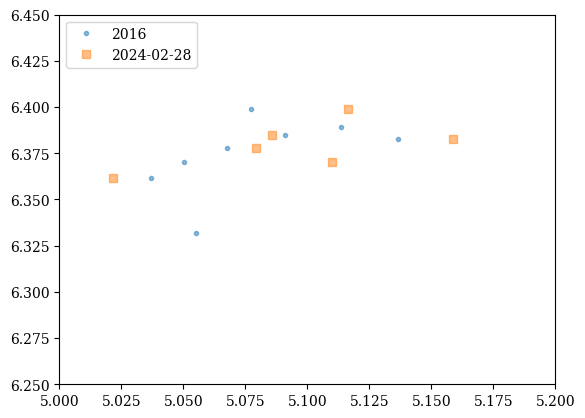

In [31]:
# 결과 출력
plt.plot(star_coord.ra.deg, star_coord.dec.deg, '.', alpha=0.5, label='2016')
plt.plot(star_coord_now.ra.deg, star_coord.dec.deg, 's', alpha=0.5, label='2024-02-28')
plt.xlim([5, 5.2])
plt.ylim([6.25, 6.45])
plt.legend()